In [1]:
import torch
import numpy as np

### Image to Token Embedding
![](https://i.imgur.com/4MXVwO5.png)

### Index 
- [Image to Patch](#image-to-patch)
    - [Visualize Image Patch Creation](#visualize-image-patch-creation)
    - [Create Non-Overlapping Patch with Conv2D](#create-non-overlapping-patch-with-conv2d)
    - [`PatchExtractor` Class](#patchextractor-class)
    - [Visualize Patch Extraction](#visualize-patch-extraction)
- [Patch Tokenization](#patchtokenizer-class)
    - [Visualize Patch to Sequence of Tokens](#visualize-patch-to-sequence-of-tokens)
- [Patch Token Embedding](#patchtokenembedding-class)
    - [Visualize Patch Token Embedding](#visualize-patch-token-embedding)
- [Put all Together the `ImageTokenizer` Class](#imagetokenizer-class)

***

## Image to Patch
[Return to index](#index)

![](https://i.imgur.com/NHh1Mug.png)

In [2]:
height = 224
width = 224
color_channels = 3
patch_size = 16

number_patches = int((height * width) / (patch_size**2))

### Import image from web and pre-processing it

In [3]:
from pathlib import Path
import matplotlib.pyplot as plt
from PIL import Image
from torchvision.transforms import ToTensor
from torchvision.transforms import Compose, Resize, ToTensor
import wget

In [4]:
def download_web_image(
    filename : str = "web_image", 
    destination : str = "../modeling/data",
):
    url = "https://i.imgur.com/o0uWjQz.png"
    img_destination = Path(destination) / f"{filename}.png"

    if img_destination.exists():
        print(f"[ERROR] : File {filename} already exist in {img_destination}...")
        return (img_destination)
    else :
        img_path = wget.download(url)
        moved_file_path = Path(img_path).rename(img_destination)
        print(f"[INFO] : Move {img_path} here : {moved_file_path}")
        return (moved_file_path)

In [5]:
img_path = download_web_image(
    filename="optimus",
    destination="../modeling/data"
)

img_path

[ERROR] : File optimus already exist in ../modeling/data/optimus.png...


PosixPath('../modeling/data/optimus.png')

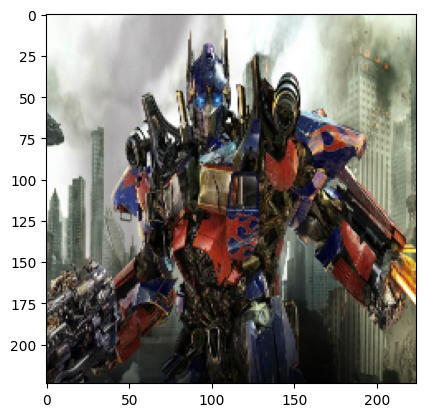

In [6]:
preprocessing = Compose([
    ToTensor(),
    Resize(size=(224, 224)),
])
    

image = Image.open(img_path)

img = preprocessing(image).unsqueeze(dim=0)
img_permuted = img.permute(0, 2, 3, 1)

plt.imshow(img_permuted[0])

***

### Visualize Image Patch Creation
[Return to index](#index)

In [7]:
from torch import Tensor

def visualize_img_to_patch(
    img : Tensor,
    height : int,
    width : int,
    patch_size : int
)->None:
    """
    Visualize img sliced in patch 

    Args:
        `img` (Tensor): img in shape (H x W x C)
        `height` (int): height size
        `width` (int): width size
        `patch_size` (int): patch size like (16 x 16)
    """
    
    assert height == width, "Image must have same height and width"
    assert height % patch_size == 0, "Image size must be divisible by patch size"
    
    plt.imshow(img)
    plt.show()

    ## -------------- Compute Number of Patches -------------- ##
    
    height_patches = height // patch_size
    width_patches = width // patch_size
    all_patches = height_patches * width_patches

    print(f"Number of Patches : {all_patches}\
        \nPatch Size : {(patch_size, patch_size)}\
        \nNumber of Patches per Column : {height_patches}\
        \nNumber of Patches per Row : {width_patches}")

    ## -------------- Setup Indexing for Image -------------- ##
    
    indexes_height_patch = range(0, height, patch_size)
    indexes_width_patch = range(0, width, patch_size)

    _, ax = plt.subplots(
        figsize=(height_patches, width_patches),
        nrows=width_patches,
        ncols=height_patches,
        sharex=True,
        sharey=True
    )

    ## -------------- Create Patch and display them  -------------- ##
    
    for h, index_height in enumerate(indexes_height_patch):
        
        for w, index_width in enumerate(indexes_width_patch):
            
            current_patch = img[
                index_height : index_height + patch_size,
                index_width : index_width + patch_size,
                :,
            ]
            
            ax[h, w].imshow(current_patch)
            ax[h, w].set_xticks([])
            ax[h, w].set_yticks([])
            
            
    plt.show()


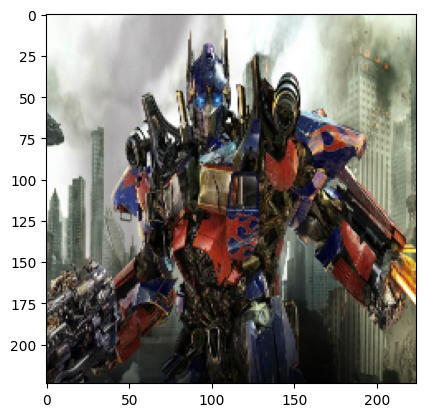

Number of Patches : 196        
Patch Size : (16, 16)        
Number of Patches per Column : 14        
Number of Patches per Row : 14


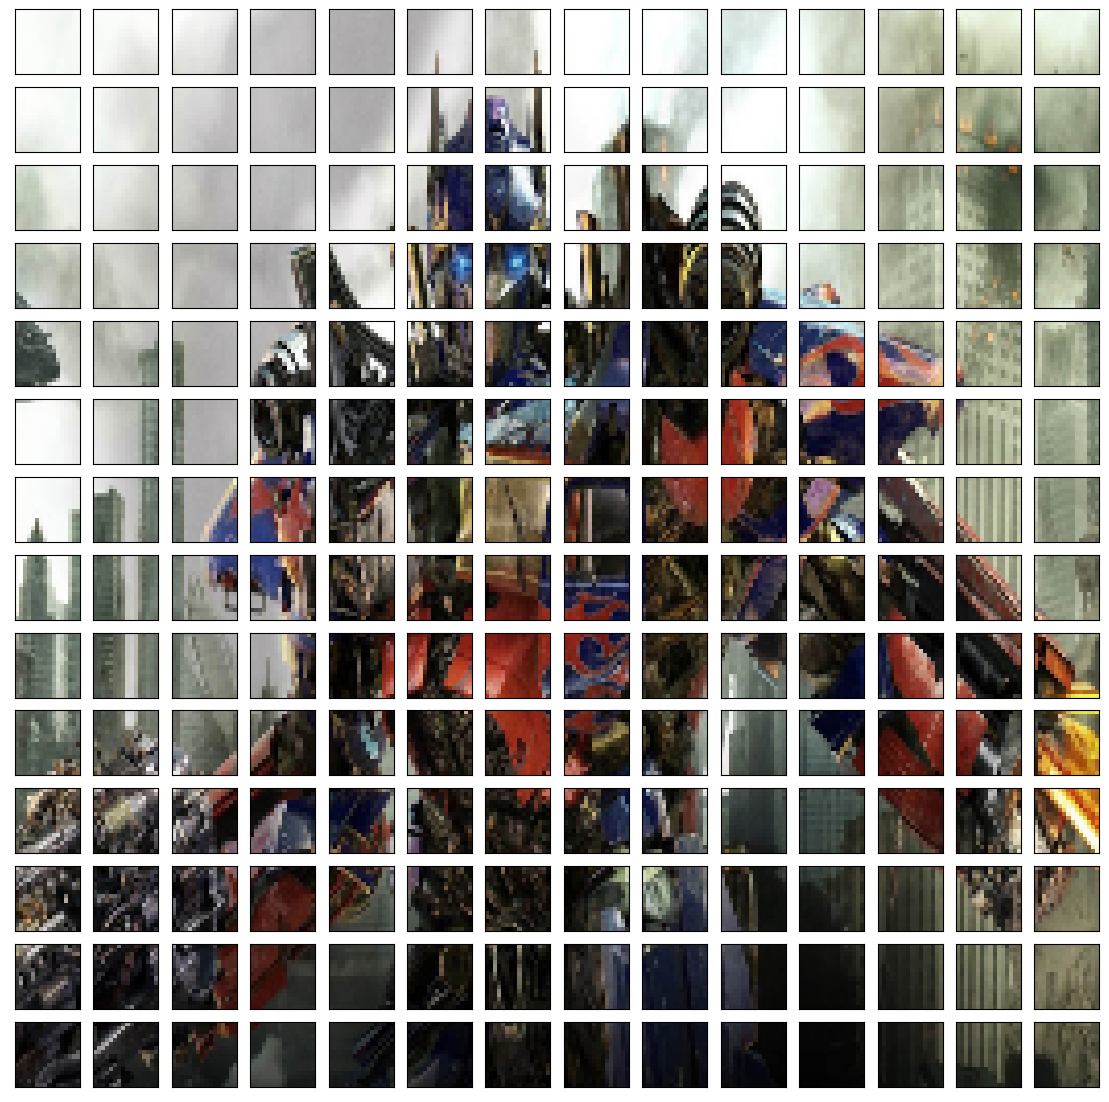

In [8]:
visualize_img_to_patch(
    img=img_permuted[0],
    height=224,
    width=224,
    patch_size=16
)

***

### Create Non-Overlapping Patch with `Conv2d` !
[Return to index](#index)

![](https://i.imgur.com/PqGZSjV.png)
- The class uses a Conv2d Layer with a kernel size a stride equal to the patch size.
- This ensures that **the convolution operation does not overlap between patches.** 
- The Conv2d layer has the same number of input and output channels, **conserving the original color information.**
***
### `PatchExtractor` Class
[Return to index](#index)

![](https://i.imgur.com/nvNNtpE.png)
- The `PatchExtractor` class is designed to divide an input image into **non-overlapping patches and extract valuable information from each patch.**
- This process allows the model to **focus on smaller, locally regions of the image and analyze local features more efficiently.**

In [9]:
from torch.nn import Module
from torch.nn import Conv2d

class PatchExtractor(Module):
    """
    Create and learn to extract valuable information in input image
    Create non-overlapping patch with Conv2d and extract 1 pixel per patch
    
    Args:
        `patch_size` (int): size of patch like 16x16
        `color_channels` (int) : number of color channels in input Image
    """
    def __init__(self, patch_size : int, color_channels : int):
        
        super().__init__()
        
        self.patch_extractor = Conv2d(
            in_channels=color_channels,
            out_channels=color_channels,
            kernel_size=(patch_size, patch_size),
            stride=patch_size
        )
    
    def forward(self, x : Tensor)->Tensor:
        """
        Extract patches information on input image

        Args:
            `x` (Tensor): input image with size (color, height, width)

        Returns:
            Tensor: Patches information of input information with shape (color, height // patch_size, width // patch_size)
        """
        patches = self.patch_extractor(x)
        
        return (patches)
        
    

torch.Size([1, 3, 14, 14])


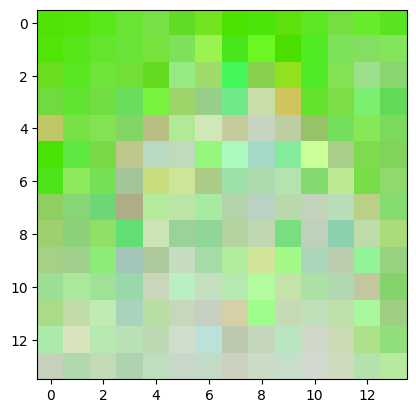

In [10]:
patches_extractor = PatchExtractor(patch_size=16, color_channels=3)

patches = patches_extractor(img)
print(patches.shape)

patch_permuted = patches.permute(0, 2, 3, 1)
patch_numpy = patch_permuted.detach().numpy()
patch_numpy = (patch_numpy - np.min(patch_numpy)) / (np.max(patch_numpy) - np.min(patch_numpy))

plt.imshow(patch_numpy[0], cmap="viridis")


#### Visualize Patch Extraction
[Return to index](#index)


In [11]:
from torch import Tensor

def visualize_patch_extraction(input_image : Tensor, patches : Tensor)->None:
    """
    Visualize an input image with its extracted patches

    Args:
        `input_image` (Tensor): input image with shape (color, height, width)
        `patches` (Tensor): patches tensor with shape (color, height, width)
    """
    
    ## -------------- Convert Tensor to Numpy Array -------------- ##
    
    input_image_permuted = input_image.permute(1, 2, 0)
    
    patch_permuted = patches.permute(1, 2, 0)
    patch_numpy = patch_permuted.detach().numpy()
    patch_numpy = (patch_numpy - np.min(patch_numpy)) / (np.max(patch_numpy) - np.min(patch_numpy))

    ## -------------- Compute Number of Patches -------------- ##
    
    height = patch_numpy.shape[0]
    width = patch_numpy.shape[1]
    
    number_patches = height * width
    print(f"Number of Patches : {number_patches}")

    ## -------------- Display Input Image -------------- ##
    
    plt.figure(figsize=(5, 5))
    plt.title(f"Input Image with Shape {input_image.shape}")
    plt.imshow(input_image_permuted)
    plt.show()
    
    ## -------------- Display Patches -------------- ##
    
    indexes_height_patch = range(0, height, 1)
    indexes_width_patch = range(0, width, 1)

    _, ax = plt.subplots(
        figsize=(5, 5),
        nrows=width,
        ncols=height,
        sharex=True,
        sharey=True
    )
    plt.suptitle(f"Patches Extracted with Shape : {patches.shape}")

    ## -------------- Indexing Image with Patches Index  -------------- ##
    
    for h, index_height in enumerate(indexes_height_patch):
        
        for w, index_width in enumerate(indexes_width_patch):
            
            current_patch = patch_numpy[
                index_height : index_height + patch_size,
                index_width : index_width + patch_size,
                :,
            ]
            
            ax[h, w].imshow(current_patch)
            ax[h, w].set_xticks([])
            ax[h, w].set_yticks([])

Number of Patches : 196


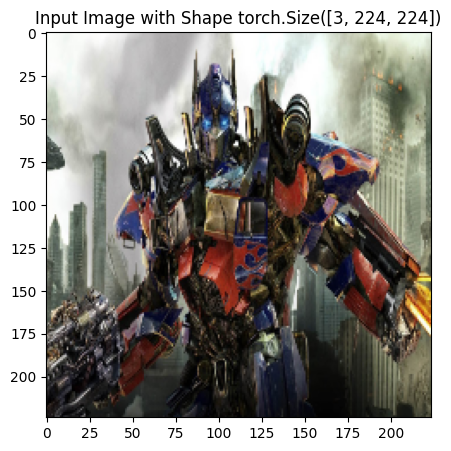

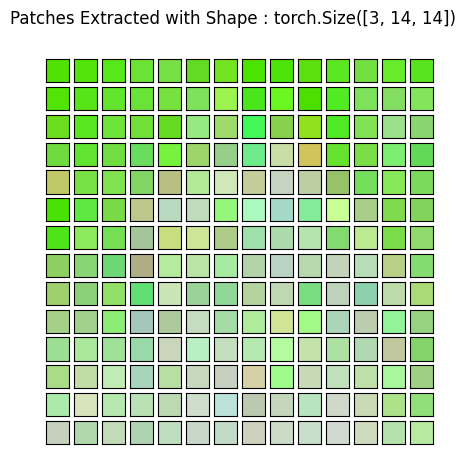

In [12]:
visualize_patch_extraction(input_image=img[0], patches=patches[0])

****

### `PatchTokenizer` Class
[Return to index](#index)

![](https://i.imgur.com/jZsYT1I.png)
- The primary purpose of this class is to transform the extracted image patches into a **sequence of tokens**, making them comprehensive by a transformer model
- The class achieves this by **flattening and reshaping the input tensor**,  to combine the height and width dimensions into a sequence of feature vectors.

In [13]:
from torch.nn import Module
from torch.nn import Flatten

class PatchTokenizer(Module): 
    """
    Convert 3D patches Tensor to sequence of patches with extracted pixels 
    Flatten and Reshape input tensor to create a sequence of feature vectors
    """
    def __init__(self):
        
        super().__init__()
        
        self.flatten = Flatten(start_dim=2, end_dim=3)
    
    def forward(self, x : Tensor)->Tensor:
        """
        Flatten spatial dimension in input tensor (batch_size, color, height * width)
        reshape it to sequence of feature vector (nbr_tokens, color)

        Args:
            `x` (Tensor): extracted pixels on patches (batch_size, color, height, width)

        Returns:
            Tensor: sequence of feature vectors (batch_size, nbr_tokens, color)
        """
        batch_size = x.shape[0]
        color = x.shape[1]
        number_patches = x.shape[2] * x.shape[3] 
        
        patches_flatten = self.flatten(x)
        
        patches_tokenized = torch.reshape(
            input=patches_flatten,
            shape=(batch_size, number_patches, color)
        ) 
        
        return (patches_tokenized)

In [14]:
tokenizer = PatchTokenizer()

patches_tokenized = tokenizer(patches)

patches_tokenized.shape

torch.Size([1, 196, 3])

#### Visualize Patch to Sequence of Tokens
[Return to index](#index)

In [15]:
def visualize_patch_tokenized(patches_tokenized : Tensor):
    """
    Visualize sequence of tokenized patch in line 

    Args:
        `tokens` (Tensor): tokenized patch with shape (batch_size, nbr_token, color)
    """
    nbr_tokens = patches_tokenized.shape[1]
    color = patches_tokenized.shape[2]
    
    tokens_numpy = patches_tokenized.detach().numpy()
    tokens_numpy = (tokens_numpy - np.min(tokens_numpy)) / (np.max(tokens_numpy) - np.min(tokens_numpy))
    
    plt.figure(figsize=(100, 7))
    plt.subplots_adjust(wspace=0.5)
    plt.suptitle(f"{nbr_tokens} Tokens (Patch) with {color} Color Channel(s) Value", fontsize=100)
    
    for t in range(nbr_tokens):
        current_token = tokens_numpy[:, t, :]
        current_token = current_token.reshape((1, 1, color))
        plt.subplot(1, nbr_tokens, t + 1)
        plt.imshow(current_token)
        plt.axis(False)

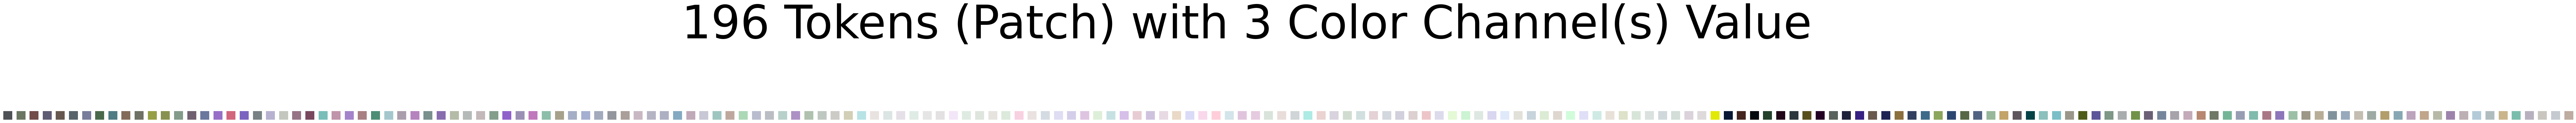

In [16]:
visualize_patch_tokenized(patches_tokenized)

***

### `PatchTokenEmbedding` Class
[Return to index](#index)

![](https://i.imgur.com/xaf3tvT.png)
$$\text{Projecting Patches into Higher-Dimensional Space}$$
- The `PatchTokenEmbedding` class is designed to convert tokenized image patches into a **more expressive representation**
- Helping the Vision Transformer to better learn and capture more complex information within the images.

In [17]:
from torch.nn import Module
from torch.nn import Linear

class PatchTokenEmbedding(Module):
    """
    Linear Projection on color channels value of tokenized patches

    Args:
        `color_channels` (int): nbr of color channels of tokenized patches
        `embedding_size` (int): size of fixed-lenght vector for represent tokenized patches 
    """
    def __init__(self, color_channels : int, embedding_size : int):
        
        super().__init__()
        
        self.embedding = Linear(
            in_features=color_channels, 
            out_features=embedding_size
        )
    
    def forward(self, x : Tensor)->Tensor:
        """
        Apply linear projection on color channels value

        Args:
            `x` (Tensor): patches tokenized with shape (batch_size, nbr_tokens, color)

        Returns:
            Tensor: embedding tokens with shape (batch_size, nbr_tokens, embedding_size
        """
        token_embedding = self.embedding(x)
        
        return (token_embedding) 

In [18]:
embedder = PatchTokenEmbedding(color_channels=3, embedding_size=768)

tokens_embedding = embedder(patches_tokenized)

tokens_embedding.shape 

torch.Size([1, 196, 768])

#### Visualize Patch Token Embedding 

In [19]:
def visualize_tokens_embedding(tokens_embedding : Tensor):
    """
    Visualize 100 first value in Embedding Vector for each tokens

    Args:
        `tokens_embedding` (Tensor): sequence of tokens with shape (batch_size, nbr_tokens, embedding_size)
    """
    nbr_tokens = tokens_embedding.shape[1]

    plt.figure(figsize=(20, 7))
    plt.subplots_adjust(wspace=0.5)
    plt.suptitle(f"{nbr_tokens} Token Embedding Vector with 100 first Value")

    for index, token in enumerate(tokens_embedding[0]):
        token_numpy = token.detach().numpy()
        token_numpy = token_numpy[:100, np.newaxis, np.newaxis]
        plt.subplot(1, nbr_tokens, index + 1)
        plt.imshow(token_numpy)
        plt.axis(False)

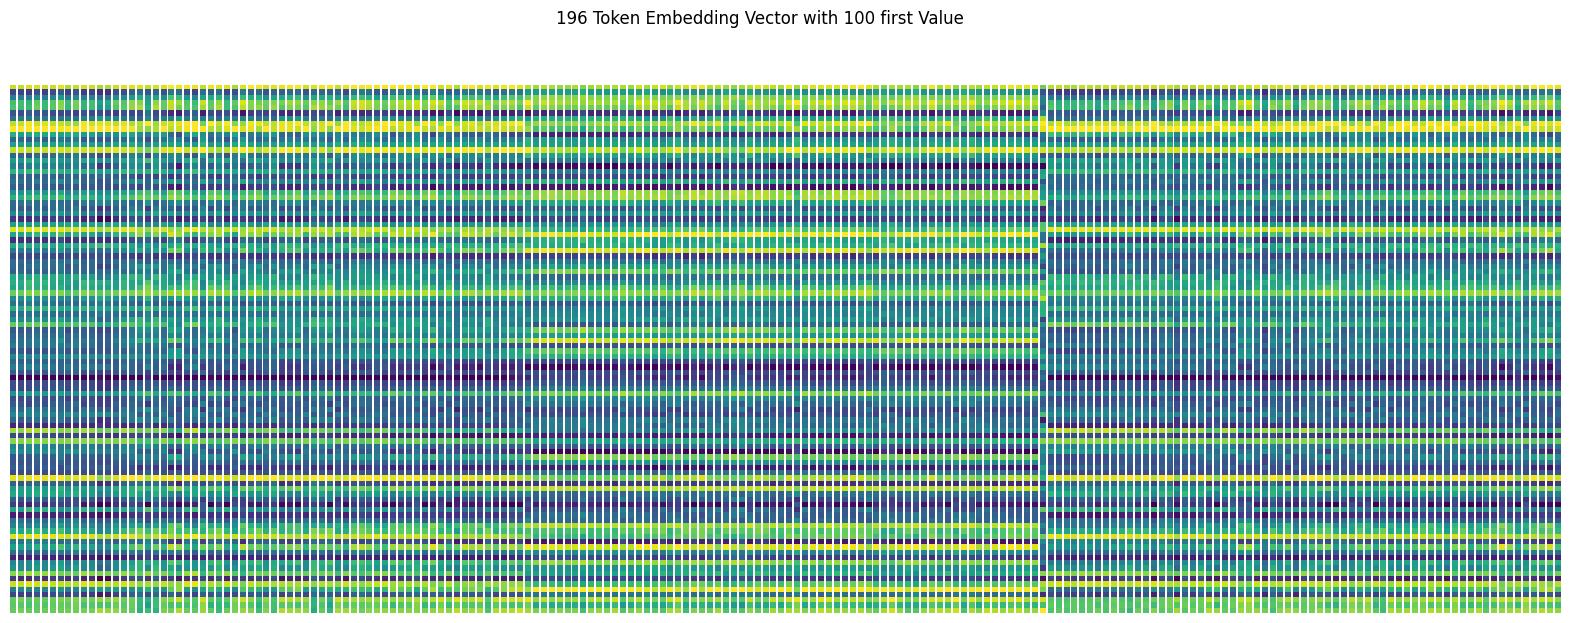

In [20]:
visualize_tokens_embedding(tokens_embedding)

***

### `ImageTokenizer` Class
[Return to index](#index)

Put all layers together to Convert Image to Embedding Tokens !

![](https://i.imgur.com/4MXVwO5.png)
$$\text{From Images to Embedding Tokens}$$

- creating patches from input images with [`PatchExtractor`](#patchextractor-class)
- tokenizing these patches with [`PatchTokenizer`](#patchtokenizer-class)
- embedding the resulting tokens with [`PatchTokenEmbedding`](#patchtokenembedding-class)


In [21]:
from torch.nn import Module

class ImageTokenizer(Module):
    """
    Create patches, extract value on it, flatten it to sequence of tokens and embedding tokens

    Args:
        `patch_size` (int): size of created patches 
        `color_channels` (int): nbr of color channels in input image
        `embedding_size` (int): size of fixed-lenght vector of embedding tokens
    """
    def __init__(self, patch_size : int, color_channels : int, embedding_size : int):
        
        super().__init__()
        
        self.patch_extractor = PatchExtractor(
            patch_size=patch_size,
            color_channels=color_channels
        )
        
        self.patch_tokenizer = PatchTokenizer()
        
        self.token_embedding = PatchTokenEmbedding(
            color_channels=3, 
            embedding_size=embedding_size
        )
        
    def forward(self, x : Tensor)->Tensor:
        """
        Extract patch with `PatchExtractor`
        Tokenize patch into sequence with `PatchTokenizer`
        Embedding tokenized patch with `PatchTokenEmbedding`

        Args:
            x (Tensor): input image with shape (batch_size, color, height, width)

        Returns:
            Tensor: sequence of embedding tokens with shape (batch_size, nbr_tokens, embedding_size)
        """
        patches = self.patch_extractor(x)
        patches_tokenized = self.patch_tokenizer(patches)
        tokens_embedding = self.token_embedding(patches_tokenized)
        
        return (tokens_embedding)


In [22]:
image_tokenizer = ImageTokenizer(
    patch_size=16, 
    color_channels=3, 
    embedding_size=768
)

tokens = image_tokenizer(img)

tokens.shape

torch.Size([1, 196, 768])